In [1]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from ipywidgets import widgets
from IPython.display import display, clear_output

In [2]:
%run functions_models_12345.ipynb

## Create two classes, Model and State.  

### The class Model will store instances of different constitutive models.  The class State will store instances of different state variables such as stress, strain, or internal variables.


In [3]:
class Model:
    def __init__(self,**kwargs):
        for attr in kwargs.keys():
            self.__dict__[attr] = kwargs[attr]

class State:
    def __init__(self,**kwargs):
        for attr in kwargs.keys():
            self.__dict__[attr] = kwargs[attr]    


In [4]:
# Example of State:

Initial_state = State(
    stress   = np.array([200,200,200,0,0,0]),   # stress, kPa
    strain   = np.array([0,0,0,0,0,0]),         # strain
    strainp  = np.array([0,0,0,0,0,0]),         # plastic strain
    k        = 1.2,                             # initial size of yield surface, kPa (for VM)
                                                # initial 'size' (slope) of yield surface (for DP_hardening)
    alpha    = np.array([0, 0, 0, 0, 0, 0]),    # initial back-stress, kPa (for VM)
                                                # initial back-stress ratio (for DP_hardening)
    p0       = np.array([200]),                 # initial p0 value (for MCC)
    e        = np.array([1.75])                 # initial void ratio (for MCC)
)  


# Example of Model:

DP_1 = Model(name = 'DP',
           K    = 50e3,             # elastic bulk modulus, kPa
           G    = 25e3,             # elastic shear modulus, kPa
           phi  = 37/180*np.pi,     # frictional angle, rad
           c    = 0,                # cohension, kPa
           psi  = 37/180*np.pi      # if equal to Model.phi, associate flow rule
          )                         # otherwise, non-associate, rad


MC_1 = Model(name = 'MC',             
           K    = 50e3,             # elastic bulk modulus, kPa             
           G    = 25e3,             # elastic shear modulus, kPa             
           phi  = 37/180*np.pi,     # frictional angle, rad             
           c    = 0,                # cohension, kPa             
           psi  = 10/180*np.pi      # if equal to Model.phi, associate flow rule           
          )                         # otherwise, non-associate, rad

VM_1 = Model(name  = 'VM',
           K     = 200e3/(3*(1-2*0.3)),         # elastic bulk modulus, kPa
           G     = 200e3/(2*(1+0.3)),           # elastic shear modulus, kPa
           m     = 0,                           # isotropic hardening parameter
           c     = 30e3,                        # kinematic hardening parameter 1
           gamma = 100,                         # kinematic hardening parameter 2          
          )

DP_2 = Model(name  = 'DP_hardening', 
                     K     = 200e3/(3*(1-2*0.3)),        # elastic bulk modulus, kPa
                     G     = 200e3/(2*(1+0.3)),          # elastic shear modulus, kPa
                     m     = 20,                         # isotropic hardening parameter
                     c     = 30,                         # kinematic hardening parameter 1
                     gamma = 10,                         # kinematic hardening parameter 2
                     D     = 0.25,                       # 'dilation'                    
                 )

MCC_1 = Model(name  = 'MCC', 
                     Lambda = 0.28,        # slope of normal consolidation line in e - ln(p)
                     Kappa  = 0.02,        # slope of rebound line in e - ln (p)
                     M      = 0.89,        # slope of CSL in q - p space
                     v      = 0.15         # Poisson's ratio        
            )



## Define yield surface and compute f with given stress and state parameters

In [5]:
def yieldSurface(sigm, Model, State):
    J1, J2D, theta = invariant(sigm)
    p = J1 / 3
    s = sigm - p * I
    
    if Model.name == 'DP':
    
        alpha = 2 * np.sin(Model.phi) / (np.sqrt(3) * (3-np.sin(Model.phi)))
        k = 6 * Model.c * np.cos(Model.phi) / (np.sqrt(3) * (3-np.sin(Model.phi)))
        f_pred = np.real(np.emath.sqrt(J2D)) - alpha * J1 - k
        
    if Model.name == 'MC':
        
        f_pred = -1/3*J1*np.sin(Model.phi)+np.sqrt(J2D)*(np.cos(theta)+1/np.sqrt(3)*np.sin(theta)*np.sin(Model.phi))-Model.c*np.cos(Model.phi)
     
    if Model.name == 'VM':
        temp = s - State.alpha
        f_pred = colonProduct(temp,temp) - 2/3 * State.k**2
        
    if Model.name == 'DP_hardening':
        temp = s - p * State.alpha
        f_pred = colonProduct(temp,temp) - 2/3 * State.k**2  * p**2
        
    if Model.name == 'MCC':
        f_pred = 3 * J2D - Model.M**2 * J1 / 3 * (State.p0 - J1/3)
        
    return f_pred
           


## Define a function to compute $\frac{\partial f}{\partial \sigma}$

In [6]:
def fnormal(sigm, Model, State):
    J1, J2D, theta = invariant(sigm)
  
    p = J1 / 3
    s = sigm - p * I

    a1 = I
    a2 = 1/(2*np.sqrt(J2D))*s;
    a2[3:6] = a2[3:6] * 2;
    a3 = np.array([s[1]*s[2]-s[5]**2+J2D/3,
                   s[0]*s[2]-s[4]**2+J2D/3,
                   s[0]*s[1]-s[3]**2+J2D/3,
                   2*(s[4]*s[5]-s[2]*s[3]),
                   2*(s[3]*s[5]-s[1]*s[4]),
                   2*(s[3]*s[4]-s[1]*s[5])])

    if Model.name == 'DP':
        alpha = 2*np.sin(Model.phi)/(np.sqrt(3)*(3-np.sin(Model.phi)))
        k = 6*Model.c*np.cos(Model.phi)/(np.sqrt(3)*(3-np.sin(Model.phi)));
        dfds = a2-alpha*a1;

    if Model.name == 'MC':
        C1 = -1/3*np.sin(Model.phi)
        if np.abs(theta+np.pi/6) < 1e-6:
            C2 = 1/2*(np.sqrt(3)-np.sin(Model.phi)/np.sqrt(3))
            C3 = 0
        elif np.abs(theta-np.pi/6) < 1e-6:
            C2 = 1/2*(np.sqrt(3)+np.sin(Model.phi)/np.sqrt(3))
            C3 = 0
        else:
            C2 = np.cos(theta)*(1+np.tan(theta)*np.tan(3*theta)+np.sin(Model.phi)*(-np.tan(3*theta)+np.tan(theta))/np.sqrt(3))
            C3 = (np.sqrt(3)*np.sin(theta)-np.cos(theta)*np.sin(Model.phi))/(2*J2D*np.cos(3*theta))

        dfds = C1*a1+C2*a2+C3*a3

    if Model.name == 'VM':
        dfds = 2*(s - State.alpha)

    if Model.name == 'DP_hardening':
        temp = colonProduct(State.alpha, s - p * State.alpha)
        dfds = 2 * (s - p * State.alpha) - 2/3 * temp * I - 4/9 * State.k**2 * p * I

    if Model.name == 'MCC':
        dfds = 3*s + Model.M**2/3*(2*p - State.p0)*I
    
    return dfds
            
            
    
    
        
        
    

## Define a function to compute $\frac{\partial g}{\partial \sigma}$

In [7]:
def gnormal(sigm, Model, State):
    J1, J2D, theta = invariant(sigm)
    

    p = J1 / 3
    s = sigm - p * I

    a1 = I
    a2 = 1/(2*np.sqrt(J2D))*s;
    a2[3:6] = a2[3:6] * 2;
    a3 = np.array([s[1]*s[2]-s[5]**2+J2D/3,
                   s[0]*s[2]-s[4]**2+J2D/3,
                   s[0]*s[1]-s[3]**2+J2D/3,
                   2*(s[4]*s[5]-s[2]*s[3]),
                   2*(s[3]*s[5]-s[1]*s[4]),
                   2*(s[3]*s[4]-s[1]*s[5])])

    if Model.name == 'DP':
        alpha_phi = 2*np.sin(Model.psi)/(np.sqrt(3)*(3-np.sin(Model.psi)))
        dgds = a2-alpha_phi*a1;

    if Model.name == 'MC':
        C1 = -1/3*np.sin(Model.psi)
        if np.abs(theta+np.pi/6) < 1e-6:
            C2 = 1/2*(np.sqrt(3)-np.sin(Model.psi)/np.sqrt(3))
            C3 = 0
        elif np.abs(theta-np.pi/6) < 1e-6:
            C2 = 1/2*(np.sqrt(3)+np.sin(Model.psi)/np.sqrt(3))
            C3 = 0
        else:
            C2 = np.cos(theta)*(1+np.tan(theta)*np.tan(3*theta)+np.sin(Model.psi)*(-np.tan(3*theta)+np.tan(theta))/np.sqrt(3))
            C3 = (np.sqrt(3)*np.sin(theta)-np.cos(theta)*np.sin(Model.psi))/(2*J2D*np.cos(3*theta))

        dgds = C1*a1+C2*a2+C3*a3

    if Model.name == 'VM':
        dgds = 2*(s - State.alpha)

    if Model.name == 'DP_hardening':
        dgds = 2 * (s - p * State.alpha) + 1/3 * Model.D * I

    if Model.name == 'MCC':
        dgds = 3*s + Model.M**2/3*(2*p - State.p0)*I            
            
    return dgds
            
  

## Define a function to compute $K_p$

In [8]:
def plasticModulus(sigm, Model, State):
    p = (sigm[0]+sigm[1]+sigm[2]) / 3
    s = sigm - p * I
    
    if Model.name == 'DP' or 'MC':
        Kp = 0
        
    if Model.name == 'VM':
        dfdalpha = -2 * (s - State.alpha)
        dfdk = -4/3 * State.k 
        alpha_bar = (4/3 * Model.c * (s - State.alpha) 
                    - 2/np.sqrt(3) * Model.gamma * State.alpha * np.sqrt(2 * colonProduct(s - State.alpha, s - State.alpha))
                    )
        k_bar = Model.m * np.sqrt(2 * colonProduct(s - State.alpha, s - State.alpha))
        Kp = -dfdk * k_bar - colonProduct(dfdalpha, alpha_bar)
    
    if Model.name == 'DP_hardening':
        dfdalpha = -2 * p * (s - p * State.alpha)
        dfdk = -4/3 * State.k * p**2
        alpha_bar = (2/3 * Model.c * (2 * (s - p * State.alpha) + 1/3 * Model.D * I) 
                    - 2/np.sqrt(3) * Model.gamma * State.alpha * np.sqrt(2 * colonProduct(s - p * State.alpha, s - p * State.alpha))
                    )
        k_bar = Model.m * np.sqrt(2 * colonProduct(s - p * State.alpha, s - p * State.alpha))
        Kp = -dfdk * k_bar - colonProduct(dfdalpha, alpha_bar)

    if Model.name == 'MCC':  
        Kp = Model.M**4 * p * (State.e + 1) / (Model.Lambda - Model.Kappa) * State.p0 * (2*p - State.p0)
        
    return Kp


## Update stress and strain explicitly using ${\sigma} = {\sigma} + {\dot \sigma}$ and ${\epsilon} = {\epsilon} + {\dot \epsilon}$

In [9]:
def constitutiveDriver(Model, incr, State, Load_tag):
    inc_frac = 1
    Cel = C_el(Model,State)
    deps_trial, dsigm_trial = Bardet(Cel, incr, Load_tag, inc_frac)
    
    sigm_t = State.stress + dsigm_trial
    f_pred = yieldSurface(sigm_t, Model, State)
    
    
    if f_pred <=0:     # elastic loading
        State.stress = sigm_t
        State.strain = State.strain + deps_trial
        
        State.e = State.e - (1 + State.e) * (deps_trial[0] + deps_trial[1] + deps_trial[2])
        
    else:
        if yieldSurface(State.stress, Model, State) > 0:
            beta = 0
        else:          # solve for the point where the path crosses the yield surface
            find_crosspoint = lambda x: yieldSurface(State.stress + x * dsigm_trial, Model, State)
            beta = root_scalar(find_crosspoint,bracket = [0,1]).root
            
        # update stress and strain to the point on yield surface
        State.stress = State.stress + beta * dsigm_trial
        State.strain = State.strain + beta * deps_trial
        
        # update e for MCC
        State.e = State.e - (1 + State.e) * beta * (deps_trial[0] + deps_trial[1] + deps_trial[2])
        
        # compute dfds, dgds and Kp
        dfds = fnormal(State.stress, Model, State)
        dgds = gnormal(State.stress, Model, State)
        Kp = plasticModulus(State.stress, Model, State)
        
        # form the elastoplastic tangent moduli
        temp1 = colonProduct_T4_T2(C_el(Model, State), dgds)
        temp2 = colonProduct_T4_T2(C_el(Model, State), dfds)
        num_Cepl = dyadicProduct(temp1, temp2)
        denom_L = Kp + colonProduct(dfds, temp1)
        Cepl = C_el(Model, State) - num_Cepl / denom_L
        
        # compute deps and dsigm
        inc_frac = 1 - beta
        deps, dsigm = Bardet(Cepl, incr, Load_tag, inc_frac)
        
        # compute loading index
        temp3 = colonProduct_T4_T2(Cel, deps)
        L = colonProduct(dfds, temp3) / denom_L
        
        if L > 0:
            deps_p = L * dgds
            
            # update internal variable
            if Model.name == 'VM':
                depsd_p = deps_p - (deps_p[0]+deps_p[1]+deps_p[2])/3*I
                dksi_p = np.sqrt(0.5 * colonProduct(depsd_p,depsd_p))
                dalpha = 2/3 * Model.c * deps_p - 2 / np.sqrt(3) * Model.gamma * dksi_p * State.alpha
                State.alpha = State.alpha + dalpha
                dk = Model.m * dksi_p
                State.k = State.k + dk            
            
            
            if Model.name == 'DP_hardening':
                depsd_p = deps_p - (deps_p[0]+deps_p[1]+deps_p[2])/3*I
                dksi_p = np.sqrt(0.5 * colonProduct(depsd_p,depsd_p))
                dalpha = 2/3 * Model.c * deps_p - 2 / np.sqrt(3) * Model.gamma * dksi_p * State.alpha
                State.alpha = State.alpha + dalpha
                dk = Model.m * dksi_p
                State.k = State.k + dk    
            
            if Model.name == 'MCC':
                p = (State.stress[0]+State.stress[1]+State.stress[2]) / 3
                State.e = State.e - (1 + State.e) * (deps[0]+deps[1]+deps[2])
                dp0 = L * (1 + State.e)/(Model.Lambda - Model.Kappa) * State.p0 * (2*p - State.p0) * Model.M**2
                State.p0 = State.p0 + dp0
            
        else: 
            deps_p = 0
        
        # update stress and strain 
        State.stress = State.stress + dsigm
        State.strain = State.strain +  deps
        State.strainp = State.strainp + deps_p
        
    return State
        

## Input the initial state, model parameters and testing configuration and plot the result

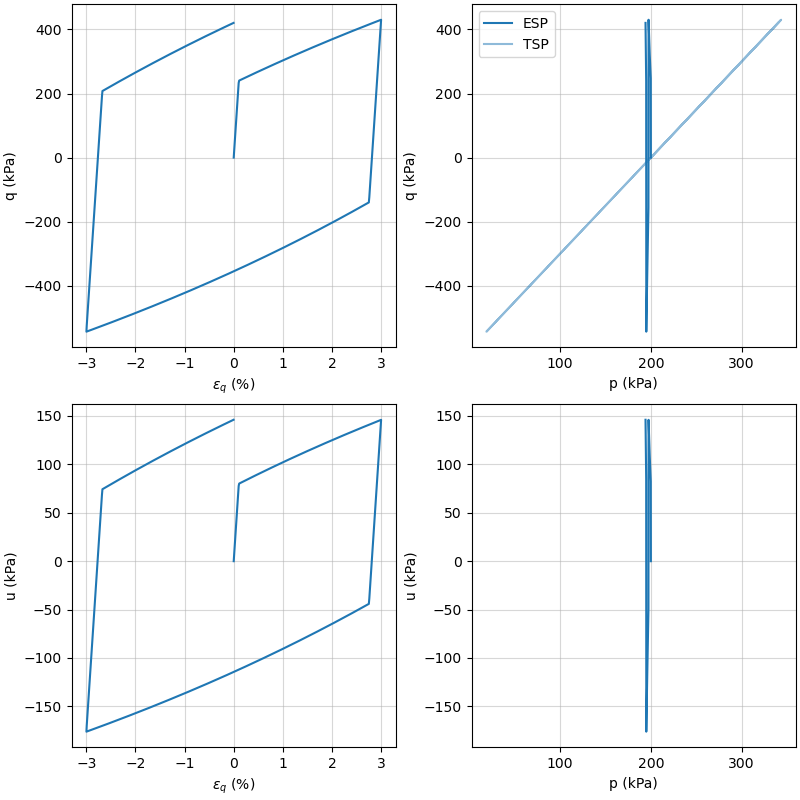

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), constrained_layout=True) # create a new figure and a set of subplots


Initial_state = State(
    stress   = np.array([200,200,200,0,0,0]),   # stress, kPa
    strain   = np.array([0,0,0,0,0,0]),         # strain
    strainp  = np.array([0,0,0,0,0,0]),         # plastic strain
    k        = 1.2,                             # initial size of yield surface, kPa (for VM)
                                                # initial 'size' (slope) of yield surface (for DP_hardening)
    alpha    = np.array([0, 0, 0, 0, 0, 0]),    # initial back-stress, kPa (for VM)
                                                # initial back-stress ratio (for DP_hardening)
    p0       = np.array([200]),                 # initial p0 value (for MCC)
    e        = np.array([1.75])                 # initial void ratio (for MCC)
)    



DP_3 = Model(name  = 'DP_hardening', 
                     K     = 200e3/(3*(1-2*0.3)),        # elastic bulk modulus, kPa
                     G     = 200e3/(2*(1+0.3)),          # elastic shear modulus, kPa
                     m     = 10,                         # isotropic hardening parameter
                     c     = 30,                         # kinematic hardening parameter 1
                     gamma = 10,                         # kinematic hardening parameter 2
                     D     = 0.25,                       # 'dilation'         
            )

result = runningModule(State = Initial_state, 
                       Model = DP_3,                      # specify which model to simulate
                       Isotropic_consolidation = 400,      # target consolidation pressure, kPa (for MCC)
                       Isotropic_unloading = None,          # target unloading pressure, kPa (for MCC)
                       Load_tag = 100,                     # 100: undrained, 110: drained
                       Load_limit = 0.03,                   # eps_a limit
                       Load_cyclic = 1,                    # 0: monotonic, 1: cyclic
                       Load_num_cyc = 1,                   # number of cycles
                       ax = ax                             # specify to plot on which figure
                    )


In [11]:
# Plot in the previous figure


Initial_state = State(
    stress   = np.array([200,200,200,0,0,0]),   # stress, kPa
    strain   = np.array([0,0,0,0,0,0]),         # strain
    strainp  = np.array([0,0,0,0,0,0]),         # plastic strain
    k        = 1.2,                             # initial size of yield surface, kPa (for VM)
                                                # initial 'size' (slope) of yield surface (for DP_hardening)
    alpha    = np.array([0, 0, 0, 0, 0, 0]),    # initial back-stress, kPa (for VM)
                                                # initial back-stress ratio (for DP_hardening)
    p0       = np.array([200]),                 # initial p0 value (for MCC)
    e        = np.array([1.75])                 # initial void ratio (for MCC)
)    



DP_4 = Model(name  = 'DP_hardening', 
                     K     = 200e3/(3*(1-2*0.3)),        # elastic bulk modulus, kPa
                     G     = 200e3/(2*(1+0.3)),          # elastic shear modulus, kPa
                     m     = 20,                         # isotropic hardening parameter
                     c     = 30,                         # kinematic hardening parameter 1
                     gamma = 10,                         # kinematic hardening parameter 2
                     D     = 0.25,                       # 'dilation'         
            )

result = runningModule(State = Initial_state, 
                       Model = DP_4,                      # specify which model to simulate
                       Isotropic_consolidation = 400,      # target consolidation pressure, kPa (for MCC)
                       Isotropic_unloading = None,          # target unloading pressure, kPa (for MCC)
                       Load_tag = 100,                     # 100: undrained, 110: drained
                       Load_limit = 0.03,                   # eps_a limit
                       Load_cyclic = 1,                    # 0: monotonic, 1: cyclic
                       Load_num_cyc = 1,                   # number of cycles
                       ax = ax                             # specify to plot on which figure
                    )


### Modified cam-clay model

/var/folders/1v/4m4qrlld78l_b2t0w4b2qvk00000gn/T/ipykernel_60463/2840376135.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  theta = 1/3 * np.real(np.emath.arcsin(-3 * np.sqrt(3) / 2 *J3D / np.emath.power(J2D,1.5)))
/var/folders/1v/4m4qrlld78l_b2t0w4b2qvk00000gn/T/ipykernel_60463/621606772.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  a2 = 1/(2*np.sqrt(J2D))*s;
/var/folders/1v/4m4qrlld78l_b2t0w4b2qvk00000gn/T/ipykernel_60463/621606772.py:8: RuntimeWarning: invalid value encountered in multiply
  a2 = 1/(2*np.sqrt(J2D))*s;
/var/folders/1v/4m4qrlld78l_b2t0w4b2qvk00000gn/T/ipykernel_60463/3440187331.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  a2 = 1/(2*np.sqrt(J2D))*s;
/var/folders/1v/4m4qrlld78l_b2t0w4b2qvk00000gn/T/ipykernel_60463/3440187331.py:9: RuntimeWarning: invalid value encountered in multiply
  a2 = 1/(2*np.sqrt(J2D))*s;
/var/folders/1v/4m4qrlld78l_b2t0w4b2qvk00000gn/T/ipykernel_60463/621606772.py:8: RuntimeWarnin

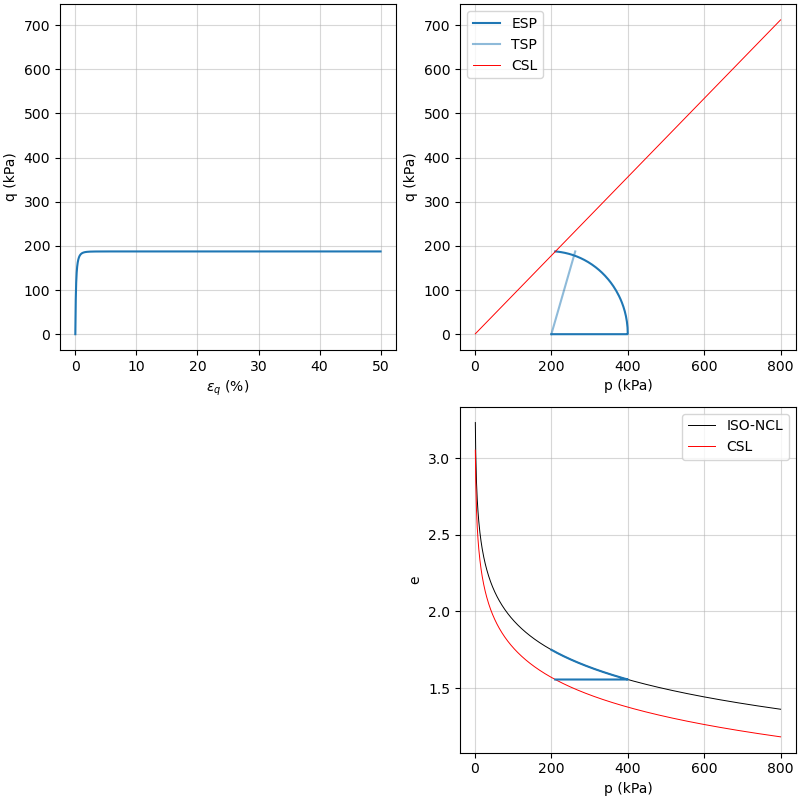

In [12]:
fig, ax2 = plt.subplots(2, 2, figsize=(8, 8), constrained_layout=True) # create a new figure and a set of subplots

Initial_state = State(
    stress   = np.array([200,200,200,0,0,0]),   # stress, kPa
    strain   = np.array([0,0,0,0,0,0]),         # strain
    strainp  = np.array([0,0,0,0,0,0]),         # plastic strain
    k        = 1.2,                             # initial size of yield surface, kPa (for VM)
                                                # initial 'size' (slope) of yield surface (for DP_hardening)
    alpha    = np.array([0, 0, 0, 0, 0, 0]),    # initial back-stress, kPa (for VM)
                                                # initial back-stress ratio (for DP_hardening)
    p0       = np.array([200]),                 # initial p0 value (for MCC)
    e        = np.array([1.75])                 # initial void ratio (for MCC)
)    



MCC_1 = Model(name  = 'MCC', 
                     Lambda = 0.28,        # slope of normal consolidation line in e - ln(p)
                     Kappa  = 0.02,        # slope of rebound line in e - ln (p)
                     M      = 0.89,        # slope of CSL in q - p space
                     v      = 0.15         # Poisson's ratio        
            )

result = runningModule(State = Initial_state, 
                       Model = MCC_1,                      # specify which model to simulate
                       Isotropic_consolidation = 400,      # target consolidation pressure, kPa (for MCC)
                       Isotropic_unloading = None,          # target unloading pressure, kPa (for MCC)
                       Load_tag = 100,                     # 100: undrained, 110: drained
                       Load_limit = 0.5,                   # eps_a limit
                       Load_cyclic = 0,                    # 0: monotonic, 1: cyclic
                       Load_num_cyc = 1,                   # number of cycles
                       ax = ax2                             # specify to plot on which figure
                    )


### Load and plot the test data of TMD11-15 on Karlsruhe fine sand

In [13]:
TMD11 = pd.read_csv('TMD11.dat', sep ='\s+', header = None ).drop([8,9,10],axis=1).drop([0,1]).reset_index(drop=True)
TMD11.columns=['eps1', 'epsv', 'eps3', 'epsq', 'void_ratio', 'q', 'p', 'eta']
TMD11 = TMD11.astype(float)
TMD12 = pd.read_csv('TMD12.dat', sep ='\s+', header = None ).drop([8,9,10],axis=1).drop([0,1]).reset_index(drop=True)
TMD12.columns=['eps1', 'epsv', 'eps3', 'epsq', 'void_ratio', 'q', 'p', 'eta']
TMD12 = TMD12.astype(float)
TMD13 = pd.read_csv('TMD13.dat', sep ='\s+', header = None ).drop([8,9,10],axis=1).drop([0,1]).reset_index(drop=True)
TMD13.columns=['eps1', 'epsv', 'eps3', 'epsq', 'void_ratio', 'q', 'p', 'eta']
TMD13 = TMD13.astype(float)
TMD14 = pd.read_csv('TMD14.dat', sep ='\s+', header = None ).drop([8,9,10],axis=1).drop([0,1]).reset_index(drop=True)
TMD14.columns=['eps1', 'epsv', 'eps3', 'epsq', 'void_ratio', 'q', 'p', 'eta']
TMD14 = TMD14.astype(float)
TMD15 = pd.read_csv('TMD15.dat', sep ='\s+', header = None ).drop([8,9,10],axis=1).drop([0,1]).reset_index(drop=True)
TMD15.columns=['eps1', 'epsv', 'eps3', 'epsq', 'void_ratio', 'q', 'p', 'eta']
TMD15 = TMD15.astype(float)


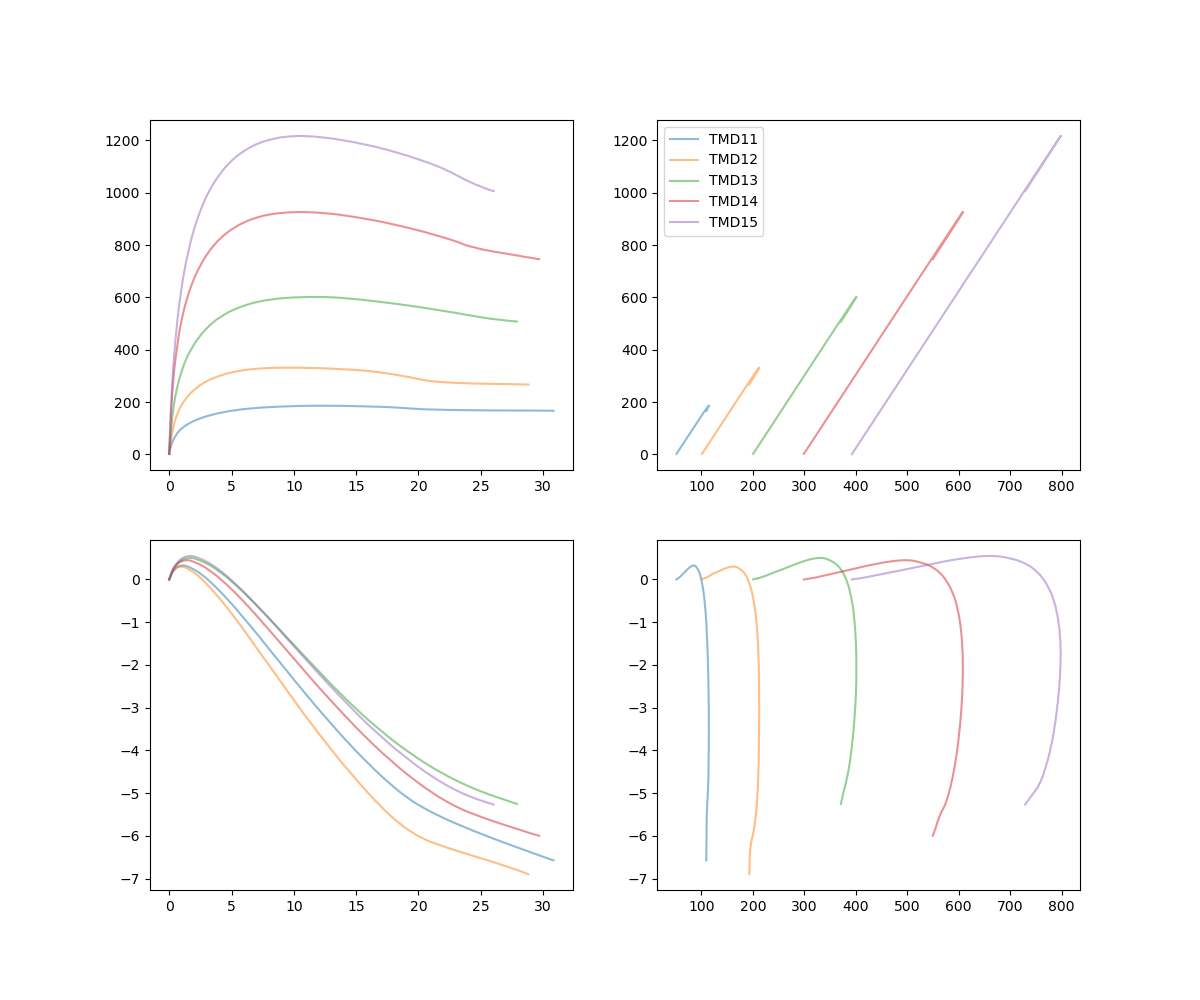

In [14]:
fig, ax3 = plt.subplots(2, 2, figsize=(12, 10)) 

TMD_list = ['TMD11','TMD12','TMD13','TMD14','TMD15']
for i, TMD in enumerate((TMD11,TMD12,TMD13,TMD14,TMD15)):
    ax3[0,0].plot(TMD['epsq'],TMD ['q'],label=TMD_list[i],alpha=0.5)
    ax3[0,1].plot(TMD['p'], TMD['q'],label=TMD_list[i],alpha=0.5)
    ax3[1,0].plot(TMD['epsq'], TMD['epsv'],label=TMD_list[i],alpha=0.5)
    ax3[1,1].plot(TMD['p'], TMD['epsv'],label=TMD_list[i],alpha=0.5)

ax3[0,1].legend()
    


### Calibrating model parameters and plot the results

In [15]:
# Plot in the previous figure

Initial_state = State(
    stress   = np.array([100,100,100,0,0,0]),   # stress, kPa
    strain   = np.array([0,0,0,0,0,0]),         # strain
    strainp  = np.array([0,0,0,0,0,0]),         # plastic strain
    k        = 1.2,                             # initial size of yield surface, kPa (for VM)
                                                # initial 'size' (slope) of yield surface (for DP_hardening)
    alpha    = np.array([0, 0, 0, 0, 0, 0]),    # initial back-stress, kPa (for VM)
                                                # initial back-stress ratio (for DP_hardening)
    p0       = np.array([200]),                 # initial p0 value (for MCC)
    e        = np.array([1.75])                 # initial void ratio (for MCC)
)    



DP_5 = Model(name  = 'DP_hardening', 
                     K     = 30e3,                       # elastic bulk modulus, kPa
                     G     = 15e3,                       # elastic shear modulus, kPa
                     m     = -1.5,                       # isotropic hardening parameter
                     c     = 10,                         # kinematic hardening parameter 1
                     gamma = 20,                         # kinematic hardening parameter 2
                     D     = -150,                       # 'dilation'         
            )

result = runningModule(State = Initial_state, 
                       Model = DP_5,                      # specify which model to simulate
                       Isotropic_consolidation = 400,      # target consolidation pressure, kPa (for MCC)
                       Isotropic_unloading = None,          # target unloading pressure, kPa (for MCC)
                       Load_tag = 110,                     # 100: undrained, 110: drained
                       Load_limit = 0.3,                   # eps_a limit
                       Load_cyclic = 0,                    # 0: monotonic, 1: cyclic
                       Load_num_cyc = 1,                   # number of cycles
                       ax = ax3                             # specify to plot on which figure
                    )
